In [36]:
import re
import string
import nltk
import tensorflow_datasets as tfds
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from string import punctuation
from spellchecker import SpellChecker
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from bs4 import BeautifulSoup
from tqdm import tqdm

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [37]:
# Load the IMDb reviews dataset
data = tfds.load('imdb_reviews', split={'train': 'train', 'test': 'test'})

In [38]:
# Convert the data into pandas DataFrame and decode bytes to string
train_df = tfds.as_dataframe(data['train'])
test_df = tfds.as_dataframe(data['test'])

train_df['text'] = train_df['text'].apply(lambda x: x.decode('utf-8'))
test_df['text'] = test_df['text'].apply(lambda x: x.decode('utf-8'))

train_df['label'] = train_df['label'].replace({0: 'negative', 1: 'positive'})
test_df['label'] = test_df['label'].replace({0: 'negative', 1: 'positive'})

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(train_df, train_df['label'], test_size=0.2, random_state=42, stratify=train_df['label'])

In [39]:
# Label encoding for the sentiment labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [40]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(20000, 2) (20000,)
(5000, 2) (5000,)


# Data Cleaning

In [41]:
spell = SpellChecker()
lemmatizer = WordNetLemmatizer()


def transformations(dataframe):
    # HTML Tags removal
    dataframe['text'] = dataframe['text'].apply(lambda words: re.sub('<[^<]+?>', '', words))

    # Lower case conversion
    dataframe['text'] = dataframe['text'].apply(lambda words: words.lower())

    # Word Tokenization
    dataframe['text'] = dataframe['text'].apply(word_tokenize)

    # Punctuation removal
    dataframe['text'] = dataframe['text'].apply(lambda words: [x for x in words if not x in punctuation])

    # Number removal
    dataframe['text'] = dataframe['text'].apply(lambda words: [x for x in words if not x.isdigit()])

    # Spellchecker and remove none values
    dataframe['text'] = dataframe['text'].apply(lambda words: [spell.correction(x) for x in words])
    dataframe['text'] = dataframe['text'].apply(lambda words: [x for x in words if x is not None])

    # Stopword removal
    dataframe['text'] = dataframe['text'].apply(lambda words: [x for x in words if x not in stopwords.words('english')])

    # Lemmatization
    dataframe['text'] = dataframe['text'].apply(lambda words: [lemmatizer.lemmatize(x) for x in words])

    # Join again
    dataframe['text'] = dataframe['text'].apply(lambda words: " ".join(words))

    return dataframe

In [42]:
x_train = transformations(x_train)

In [43]:
x_test = transformations(x_test)

In [44]:
x_train.head()

,label,text
15072,positive,latest film spanish director gust study child ...
9987,negative,others mentioned movie similar fly version les...
24558,positive,idea describe movie also would love provide ot...
2571,positive,ah loved movie think made laugh loud dozen tim...
16059,positive,brilliant movie drawing amazing bad ended begu...


# Vectorizer

In [53]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
vec = vec.fit(x_train.text)
train_x_bow = vec.transform(x_train.text)
test_x_bow = vec.transform(x_train.text)

# Naive Bayes with Hyperparameter Tuning

In [54]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

In [55]:
classifier = MultinomialNB()

In [56]:
alpha_ranges = {
    "alpha": [0.001, 0.01, 0.1, 1, 10.0, 100]
}

In [59]:
grid_search = GridSearchCV(classifier, param_grid=alpha_ranges, scoring='accuracy', cv=3, return_train_score=True)
grid_search.fit(train_x_bow, y_train)

c:\Users\User\OneDrive - METRO\Desktop\Uni\Dis25 - Haak\Exam\dis25_nlp\.venv\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


GridSearchCV(cv=3, estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10.0, 100]},
             return_train_score=True, scoring='accuracy')

In [60]:
alpha = [0.001, 0.01, 0.1, 1, 10.0, 100]
train_acc = grid_search.cv_results_['mean_train_score']
train_std = grid_search.cv_results_['std_train_score']

test_acc = grid_search.cv_results_['mean_test_score']
test_std = grid_search.cv_results_['std_test_score']

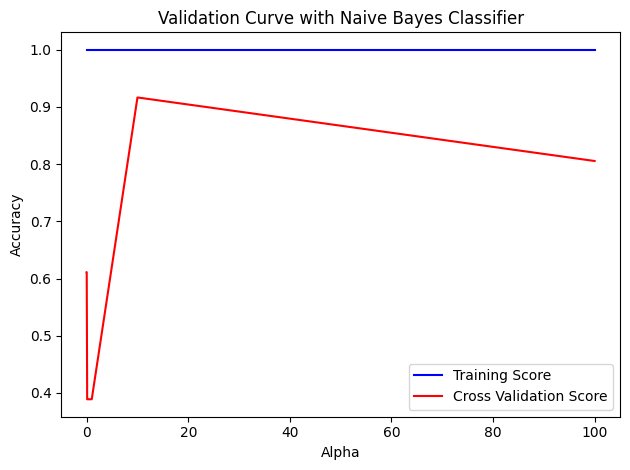

In [61]:
import matplotlib.pyplot as plt

plt.plot(alpha, train_acc, label="Training Score", color='b')
plt.plot(alpha, test_acc, label="Cross Validation Score", color='r')

plt.title("Validation Curve with Naive Bayes Classifier")
plt.xlabel("Alpha")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.legend(loc = 'best')
plt.show()


In [62]:
grid_search.best_estimator_

classifier = MultinomialNB(alpha=1)
classifier.fit(train_x_bow, y_train)

MultinomialNB(alpha=1)

In [68]:
predict = classifier.predict(test_x_bow)

In [70]:
from sklearn.metrics import accuracy_score
print("Accuracy is ", accuracy_score(y_test, predict))

Accuracy is  0.4


In [71]:
from sklearn.metrics import classification_report
print("Accuracy is ", classification_report(y_test, predict))

Accuracy is                precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      0.67      0.57         3

    accuracy                           0.40         5
   macro avg       0.25      0.33      0.29         5
weighted avg       0.30      0.40      0.34         5

